# Tutorial 02: CommonOcean-io Interface

The collision checker library provides a convenient interface to *commonocean-io*. In order to illustrate the functionality, we load a CommonOcean scenario.


/home/maioneb/.conda/envs/co38/lib/python3.8/site-packages/commonocean/visualization/traffic_sign.py:159: UserWarning: No png file for traffic sign id TrafficSignElementID.LATERAL_MARK_RED_A exists under path /home/maioneb/.conda/envs/co38/lib/python3.8/site-packages/commonocean/visualization/traffic_signs/101.png, skipped plotting.
  warnings.warn(


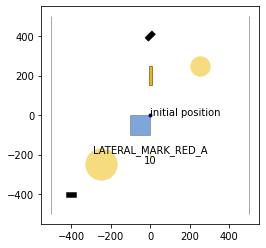

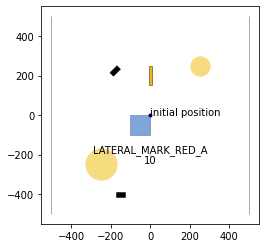

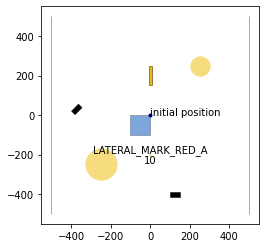

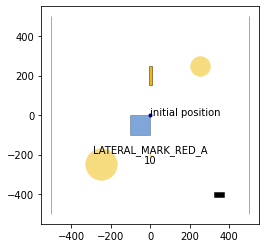

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt

from commonocean.common.file_reader import CommonOceanFileReader
from commonocean.visualization.draw_dispatch_cr import draw_object

# load the exemplary CommonOcean scenario using the CommonOceanFileReader
scenario, planning_problem_set = CommonOceanFileReader('CommonOceanDC_Tutorial.xml').open()

for j in [0,50, 105, 150]:
    draw_object(scenario, draw_params={'time_begin': j, 'trajectory_steps': 0})
    draw_object(planning_problem_set, draw_params={'time_begin': j})
    plt.gca().set_aspect('equal')
    plt.show()

## 1. Converting CommonOcean Objects to Collision Objects

All shapes and obstacles can be converted to collision objects in order to perform intersection tests. Therefore, we need to call the function 'create_collision_object()'. The supported CommonOcean objects are:

    - commonroad.geometry.shape.ShapeGroup
    - commonroad.geometry.shape.Polygon
    - commonroad.geometry.shape.Circle
    - commonroad.geometry.shape.Rectangle
    - commonocean.scenario.obstacle.StaticObstacle
    - commonocean.scenario.obstacle.DynamicObstacle
    - commonocean.scenario.waters.Shallow
    - commonocean.prediction.prediction.SetBasedPrediction
    - commonocean.prediction.prediction.TrajectoryPrediction
    
Note that the trajectories of dynamic obstacles are not interpolated. So collisions are only considered at discrete points in time.

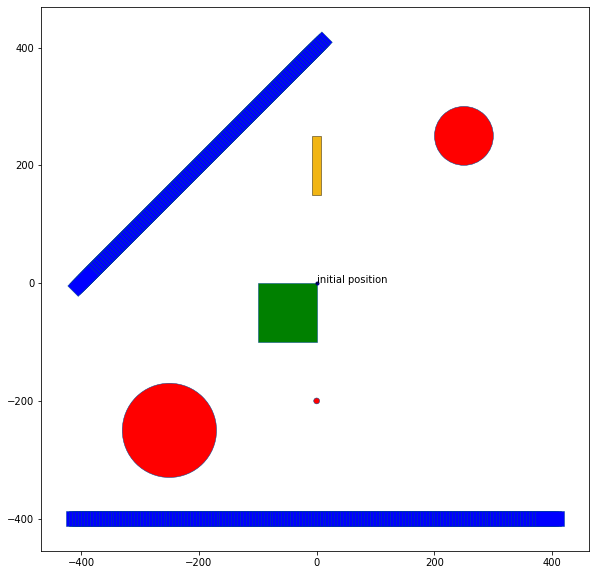

In [2]:
from commonocean_dc.collision.collision_detection.pycrcc_collision_dispatch import create_collision_object
from commonroad.visualization.mp_renderer import MPRenderer

rnd = MPRenderer(figsize=(25, 10))

# convert each static obstacle in the scenario to a collision object and plot it
for obs in scenario.static_obstacles:
    rnd.draw_params.shape.facecolor = "red"
    create_collision_object(obs).draw(rnd)

# convert each dynamic obstacle in the scenario to a collision object and plot it
for obs in scenario.dynamic_obstacles:
    rnd.draw_params.shape.facecolor = "blue"
    create_collision_object(obs).draw(rnd)
    
for shallow in scenario.shallows:
    rnd.draw_params.shape.facecolor = "green"
    create_collision_object(shallow).draw(rnd)

rnd.render()

draw_object(planning_problem_set, draw_params={'time_begin': 0})
plt.gca().set_aspect('equal')
plt.show()

## 2. Creating a Collision Checker from the Scenario

A pycrcc.CollisionChecker object can be directly generated from a CommonOcean scenario:

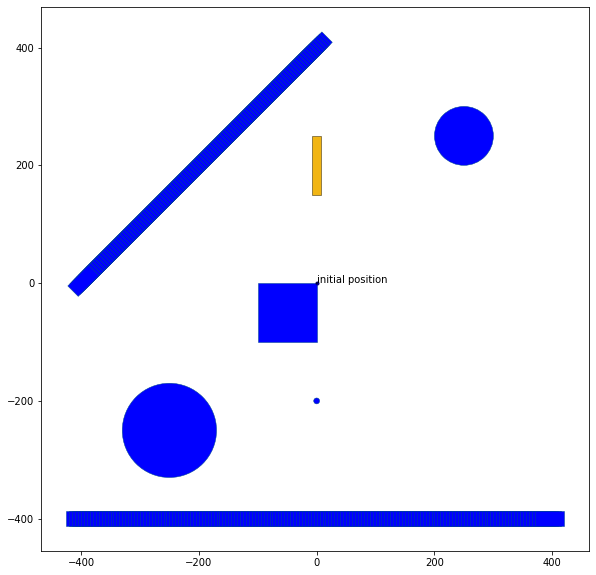

In [3]:
from commonocean_dc.collision.collision_detection.pycrcc_collision_dispatch import create_collision_checker

cc = create_collision_checker(scenario)

rnd = MPRenderer(figsize=(25, 10))

rnd.draw_params.shape.facecolor = "blue"
cc.draw(rnd)
rnd.render()

draw_object(planning_problem_set, draw_params={'time_begin': 0})
plt.gca().set_aspect('equal')
plt.show()

Given the collision checker for the scenario, it can be easily checked if a trajectory of an ego vessel collides with an object in the environment.

Collision between the trajectory of the ego vehicle and objects in the environment:  True


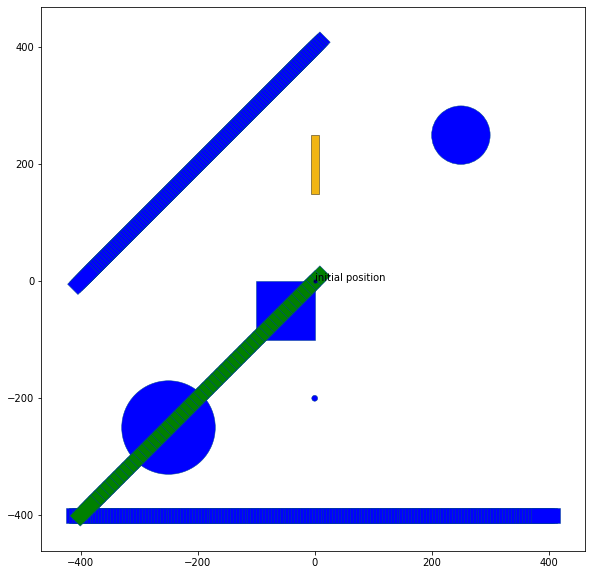

In [4]:
import numpy as np
from commonocean.scenario.trajectory import Trajectory
from commonocean.scenario.state import GeneralState

from commonocean.prediction.prediction import TrajectoryPrediction

from commonroad.geometry.shape import Rectangle

# create a trajectory for the ego vessel starting at time step 0
pos_list = []
for t in range(50):
    pos_list.append([-t*8,-t*8])
position = np.array(pos_list)
state_list = list()
for k in range(0, len(position)):
    state_list.append(GeneralState(**{'time_step':k,'position': position[k], 'orientation': 3.1416*5/4}))
trajectory = Trajectory(0, state_list)

# create the shape of the ego vehicle
shape = Rectangle(length=50, width=25)
# create a TrajectoryPrediction object consisting of the trajectory and the shape of the ego vehicle
traj_pred = TrajectoryPrediction(trajectory=trajectory, shape=shape)

# create a collision object using the trajectory prediction of the ego vehicle
co = create_collision_object(traj_pred)

# test the trajectory of the ego vehicle for collisions
print('Collision between the trajectory of the ego vehicle and objects in the environment: ', cc.collide(co))

rnd = MPRenderer(figsize=(25, 10))

rnd.draw_params.shape.facecolor = "blue"
cc.draw(rnd)
rnd.draw_params.shape.facecolor = "green"
co.draw(rnd)
rnd.render()

draw_object(planning_problem_set, draw_params={'time_begin': 0})
plt.gca().set_aspect('equal')
plt.show()

## 3. Minkowski Sum 

The *commonocean-io* interface offers the possibility to compute the minkowski sum with a circle and an arbitrary *commonocean-io* shape before adding the shape to the collision checker.

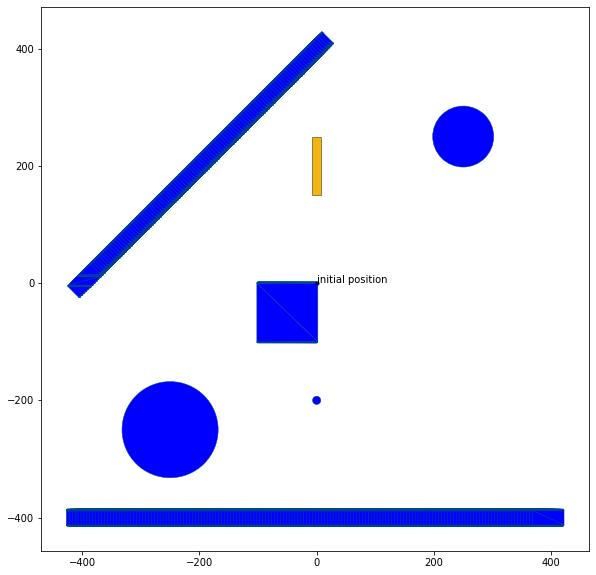

In [6]:
from commonocean_dc.collision.collision_detection.pycrcc_collision_dispatch import create_collision_checker

cc = create_collision_checker(scenario, params={'minkowski_sum_circle': True, 
                                                'minkowski_sum_circle_radius': 2.0,
                                                'resolution': 4})

rnd = MPRenderer(figsize=(25, 10))
rnd.draw_params.shape.facecolor = "blue"
rnd.draw_params.shape.draw_mesh = True
cc.draw(rnd)
rnd.render()

draw_object(planning_problem_set, draw_params={'time_begin': 0})
plt.gca().set_aspect('equal')
plt.show()

## 4. Extra: Checking if your object has the right depth

One simple question that is common while playing with scenarios is if a certain trajectory is compatible with the depth of the environment path. For that purpose, the drivability checker has its own function to turn these tests in easy tasks.

The function **has_enough_depth** can be called with a simple trajectory (and a manually chosen depth, as the trajectory calss does not have its own depth) or even with a proper dynamic obstacle object and its own depth.

As an example, let's define a new trajectory and check if it's respecting the depth of the path (with one shallow in the middle), for example. Remember that the Waters themselves have infinite depth.

Your object does not have a depth value, we used the standard value to compare (modify it through standard_depth)
Does the trajectory with depth 20 respect the path? False
Your object does not have a depth value, we used the standard value to compare (modify it through standard_depth)
Does the trajectory with depth 5 respect the path? True


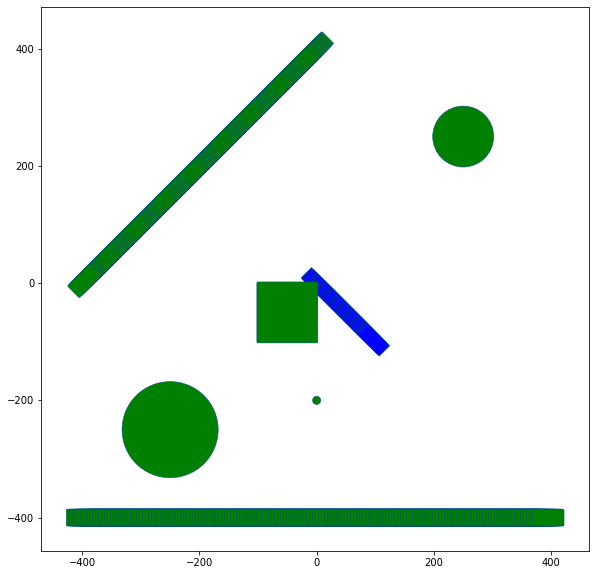

In [7]:
from commonocean_dc.boundary.boundary import has_enough_depth

pos_list = []
for t in range(50):
    pos_list.append([t*2,-t*2])
position = np.array(pos_list)
state_list = list()
for k in range(0, len(position)):
    state_list.append(GeneralState(**{'time_step':k,'position': position[k], 'orientation': 3.1416*7/4}))
trajectory = Trajectory(0, state_list)

# create the shape of the ego vehicle
shape = Rectangle(length=50, width=25)
# create a TrajectoryPrediction object consisting of the trajectory and the shape of the ego vehicle
traj_pred = TrajectoryPrediction(trajectory=trajectory, shape=shape)

rnd = MPRenderer(figsize=(25, 10))

rnd.draw_params.shape.facecolor = "blue"
create_collision_object(traj_pred).draw(rnd)
rnd.draw_params.shape.facecolor = "green"
cc.draw(rnd)
rnd.render()

result, objects = has_enough_depth(scenario, traj_pred, standard_depth=20)
print(f"Does the trajectory with depth 20 respect the path? {result}")

result, objects = has_enough_depth(scenario, traj_pred, standard_depth=5)
print(f"Does the trajectory with depth 5 respect the path? {result}")

As we manually chose the value of the standard_depth, we received some warnings. If you choose to use dynamic obstacles as the object to be tested, you don't need to worry with definying their depth values, as the function will directly use the ones from the obstacle themselves.